# Relationship between episode writer and IMDB rating for Breaking Bad episodes

The purpose of this notebook is to investigate the question below and find out if the hypothesis is correct.

### Question
Is there a relationship between the writer of an episode and its IMDB rating?

### Hypothesis
Being the creator of the series, Vince Gilligan probably writes the best episodes and, therefore, has the highest IMDB ratings.

### Basic imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Importing the dataset

In [2]:
brba = pd.read_csv('breaking_bad.csv', encoding='latin-1')
brba = brba[['Written by', 'Rating_IMDB']]
brba = brba.rename(columns = {'Written by': 'writer', 'Rating_IMDB': 'rating'})
brba.head()

,writer,rating
0,Vince Gilligan,9.1
1,Vince Gilligan,8.7
2,Vince Gilligan,8.8
3,Vince Gilligan,8.3
4,"Vince Gilligan, Patty Lin",8.4


# Data Treatment

Vince Gilligan is only credited as a writer in 13 episodes according to IMDB. However, the database puts him as a writer of every episode for being the show's creator. Therefore, it's important to correct this entry so we only count him in the episodes that he actually wrote. Reviewing the IMDB page of the show, the only episode that Gilligan didn't write alone was "Peekaboo", the sixth episode of season 2, and the show's thirteenth.

In [3]:
brba.writer.value_counts()

Vince Gilligan                                          12
Vince Gilligan, George Mastras                           7
Vince Gilligan, Peter Gould                              7
Vince Gilligan, Sam Catlin                               6
Vince Gilligan, Moira Walley-Beckett                     5
Vince Gilligan, Thomas Schnauz                           4
Vince Gilligan, Gennifer Hutchison                       4
Vince Gilligan, John Shiban                              3
Vince Gilligan, J. Roberts                               2
Vince Gilligan, Peter Gould, George Mastras              2
Vince Gilligan, George Mastras, Sam Catlin               1
Vince Gilligan, Moira Walley-Beckett, J. Roberts         1
Vince Gilligan, Thomas Schnauz, Moira Walley-Beckett     1
Vince Gilligan, Sam Catlin, George Mastras               1
Vince Gilligan, Peter Gould, Gennifer Hutchison          1
Vince Gilligan, Sam Catlin, Moira Walley-Beckett         1
Vince Gilligan, Sam Catlin, Peter Gould                 

In order to correct this problem, the code below removes Vince Gilligan from the writer's list, except for episode 13 and the episodes he appears as the sole writer.

In [4]:
# combine the chained operations (brba['writer']['index' != 12]) into a single operation using loc
# that way pandas can ensure the original DataFrame is set

brba.loc[brba.index != 12, 'writer'] = brba['writer'].str.replace(r'Vince Gilligan, ', '')
brba.head(13)

,writer,rating
0,Vince Gilligan,9.1
1,Vince Gilligan,8.7
2,Vince Gilligan,8.8
3,Vince Gilligan,8.3
4,Patty Lin,8.4
5,George Mastras,9.3
6,Peter Gould,8.9
7,J. Roberts,8.7
8,George Mastras,9.3
9,"Peter Gould, George Mastras",8.4


For this part, it was decided that each author would be analyzed individually. Therefore, the rows with more than one writer will be duplicated so the analysis won't count the string of more than one writer as a new one.

In [5]:
# split the authors in different rows
brba_split = brba.assign(writer=brba['writer'].str.split(',')).explode('writer')
brba_split.head(12)

,writer,rating
0,Vince Gilligan,9.1
1,Vince Gilligan,8.7
2,Vince Gilligan,8.8
3,Vince Gilligan,8.3
4,Patty Lin,8.4
5,George Mastras,9.3
6,Peter Gould,8.9
7,J. Roberts,8.7
8,George Mastras,9.3
9,Peter Gould,8.4


In [6]:
# fix the index
brba_split = brba_split.reset_index().rename(columns = {'index': '#episode'})
brba_split['#episode'] += 1

# clean whitespaces from the writers names
brba_split.writer = brba_split.writer.apply(lambda x: x.strip())

In [7]:
print(brba_split.shape)
brba_split.head(10)

(74, 3)


,#episode,writer,rating
0,1,Vince Gilligan,9.1
1,2,Vince Gilligan,8.7
2,3,Vince Gilligan,8.8
3,4,Vince Gilligan,8.3
4,5,Patty Lin,8.4
5,6,George Mastras,9.3
6,7,Peter Gould,8.9
7,8,J. Roberts,8.7
8,9,George Mastras,9.3
9,10,Peter Gould,8.4


# Data analysis

To begin the analysis is important to find out what is the average IMDB rating for each writer. This can provide a simple but powerful insight into the proposed question.

From the result below, there is an indication that maybe the hypothesis formulated is wrong since Vince Gilligan doesn't have the second-highest IMDB rating average. However, the difference between him in the first place, Thomas Schnauz, is only 0.02 points, so further analysis is required.

In [8]:
brba_mean = brba_split.groupby('writer').mean()['rating'].sort_values(ascending=False)
brba_mean = pd.DataFrame(brba_mean).reset_index().rename(columns = {'rating': 'average_rating'})
brba_mean

,writer,average_rating
0,Thomas Schnauz,9.142857
1,Vince Gilligan,9.123077
2,Gennifer Hutchison,9.120000
3,Peter Gould,9.072727
4,George Mastras,9.063636
5,John Shiban,8.950000
6,Moira Walley-Beckett,8.911111
7,Sam Catlin,8.830000
8,J. Roberts,8.733333
9,Patty Lin,8.400000


Calculating the standard deviation, it's expected that writers with fewer episodes will have a smaller std. Let us focus on the three writers with the highest average ratings: Thomas Schnauz, Vince Gilligan, and Gennifer Hutchinson. Comparing them, we can see that Vince Gilligan has the highest standard deviation in his ratings. However, it must be taken into account that he wrote 13 episodes, as Thomas and Gennifer wrote 7 and 6 episodes, respectively. 

In [9]:
# ddof=1 for sample standard deviation (divisor: N − 1)
# ddof=0 for population standard deviation (divisor: N)

brba_std = brba_split.groupby('writer').std(ddof=0)['rating'].sort_values(ascending=True)
brba_std = pd.DataFrame(brba_std).reset_index().rename(columns = {'rating': 'std_rating'})
brba_std

,writer,std_rating
0,Patty Lin,0.000000
1,J. Roberts,0.124722
2,John Shiban,0.357071
3,Thomas Schnauz,0.416986
4,Peter Gould,0.432941
5,Gennifer Hutchison,0.435431
6,Vince Gilligan,0.475805
7,George Mastras,0.539819
8,Sam Catlin,0.621369
9,Moira Walley-Beckett,0.640216


Since the average and standard deviation calculated left room for interpretation, we must use another tool to have a better understanding of the distribution of ratings per writer. For that, we will use a boxplot, which can summarize the data by showing the median, quartiles, and maximum and minimum values. More on boxplot can be found in this [article](https://www.robrac.org.br/seer/index.php/ROBRAC/article/download/1132/897/) (in Portuguese).

As we can see below, although Thomas and Gennifer (the last two boxes) have a lower standard deviation, Gilligan has 3 episodes with ratings above their maximum rating values and only one below their minimum. Furthermore, Gilligan's ratings present a distribution much closer to normal amongst all the writers.

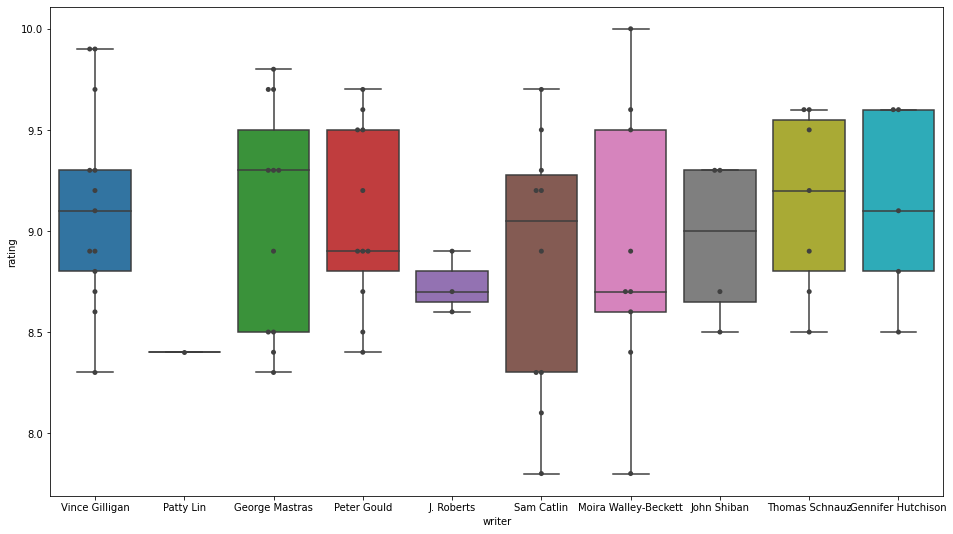

In [10]:
plt.figure(figsize=(16,9))
sns.boxplot(x="writer", y="rating", data=brba_split)

# show the data points as black dots
sns.swarmplot(x="writer", y="rating", data=brba_split, color=".25")
plt.show()

# Conclusion

To answer the posed question, higher/lower ratings don't appear to have a strong relationship with the episode's writer. The median for each writer is only a few tenths apart.

About the hypothesis, that is a bit more tricky. Although Gilligan doesn't have the highest average rating (2nd) nor the lower standard deviation (6th), we can see by the ratings that his episodes have a high quality. However, so do the majority of the other writers' ratings. Breaking Bad is broadly known as one of the best TV shows of all time for a reason. Since Gilligan is the creator and showrunner of the show, even though he did not write all episodes, they all happened under his supervision and counseling, and his mastery of storytelling is one of the many reasons why Breaking Bad is such a good drama series.